In [1]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


## Load Fashion MNISt

In [ ]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

## Completion Bar

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
    return o3           
    """
    return output

# Rotation Algorithm

In [ ]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
    return o3           
    """
    return output

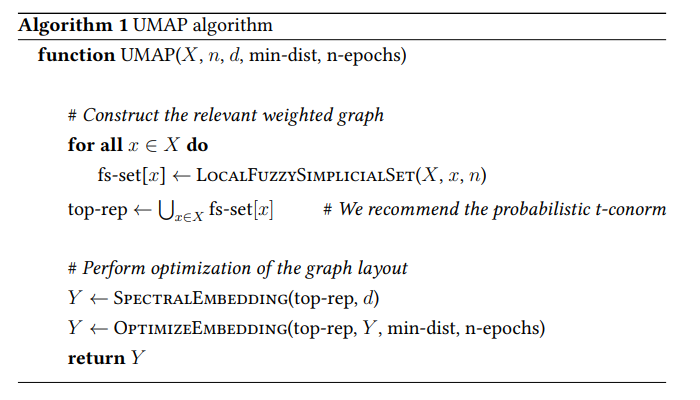

If we are going to correct for augmentations in the data for UMAP we will most likely have to do it after the construction of the fuzzy simiplical set so that we can leverage the properties of manifold learning to learn the covers of the rotational manifold. Perhaps though it may be better to instead compute 10 seperate rotational manifolds one for each data class and then sift through data prior to the construction of the fuzzy simplical set This would amount to a pre processing step in general and the main idea is that you would be feeding a cleaner input into UMAP 

By proceeding in this fashion we can accept UMAP as an algorithm that sucessfully embeds a manifold to our standards and instead focus more on refining the quality of the data. 

Suppose that for each data class a rotational manifold needs to be constructed, this implies that we need some notion of a baseline to create the rotational manifold over, how could we average the impression of each of the data classes without supervised learning to reinforce the labels for the test data?. This adjustment may simply require a degree of supervision to ensure that the data can properly be corrected. The only thing that comes to mind is perhaps a convolutional neural network which might be able to correct the image regardless of its class, this though defeats the purpose of using the topological properties of the current research paper of interest. In case we need to proceed down this route here is an implmentation: 
https://yousry.medium.com/correcting-image-orientation-using-convolutional-neural-networks-bf0f7be3a762

Maybe the only real way to proceed with this development is to understand